# Definition of Files

Import of Classes from `ICONProcessor` and definition of `.nc` Files to be used:
* Definition file of Grid: `<area>_<resolution>m_DOM<nr>.nc`
* Definition of corresponding file containing external parameters (e.g. topo, albedo, land use, etc.): `external_parameter_icon_<area>_<resolution>m_DOM<nr>_<suffix>_tiles.nc`
* Definition of output file from ICON run (contain actual variables like temperature, wind, etc.): `LES_DOM01_ML_<nr>.nc`

In [1]:
from ICONProcessor.ICONGrid import ICONGrid
from ICONProcessor.ICONDataGrid import ICONDataGrid

import geopandas as gpd
import matplotlib.pyplot as plt

## Example: HEFEX study area

The following scenarios will be used:
* 51m resolution (full grid):
    * plot surface temperature
    * rasterize data
    * plot wind map (10m or heigher model levels)

For the external parameters, the original files have been modified, e.g. the albedo values have been replaced as well as the land use category for *snow & ice* based on the RGI 7.0 outlines.

In [2]:
root_dir = '/Users/geoalxx/Python/_ICON_data/hef/'

file_51_grid       = root_dir + 'grid/hef_51m_DOM07.nc'
file_51_extpar     = root_dir + 'grid/external_parameter_icon_hef_51m_DOM07_ALBEDO_RGI_tiles.nc'
file_51_data_grid  = root_dir + 'data/LES_DOM01_ML_0016_single_t.nc'
file_51_data_point = root_dir + 'data/LES_DOM01_37433_ML.nc'

Read RGI v7.0 outlines for Central Europe as GeoDataframe. The outlines can be used for the plots.

In [3]:
rgi = gpd.read_file('/Users/geoalxx/Python/_shp_collection/RGI7/RGI2000-v7.0-G-11_central_europe/RGI2000-v7.0-G-11_central_europe.shp')
rgi_hef = rgi.loc[rgi['rgi_id'] == 'RGI2000-v7.0-G-11-03116']
display(rgi_hef)

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
3115,RGI2000-v7.0-G-11-03116,11,11-01,G010752E46802N,755531,731,2003-07-30T00:00:00,10.751768,46.802314,32,...,2413.2732,3694.625,3042.9658,3013.4644,18.13811,77.065895,3,COPDEM30,8548,"POLYGON Z ((10.75085 46.81381 0, 10.75112 46.8..."


## Plots using ICON output data

(output files usually contain only 5-6 time steps, i.e. they either need to be merged or multiple files must be loaded for longer modeling periods)

### Plot 1: Show temperature 2m above surface for one specific timestamp (incl. glacier outline)

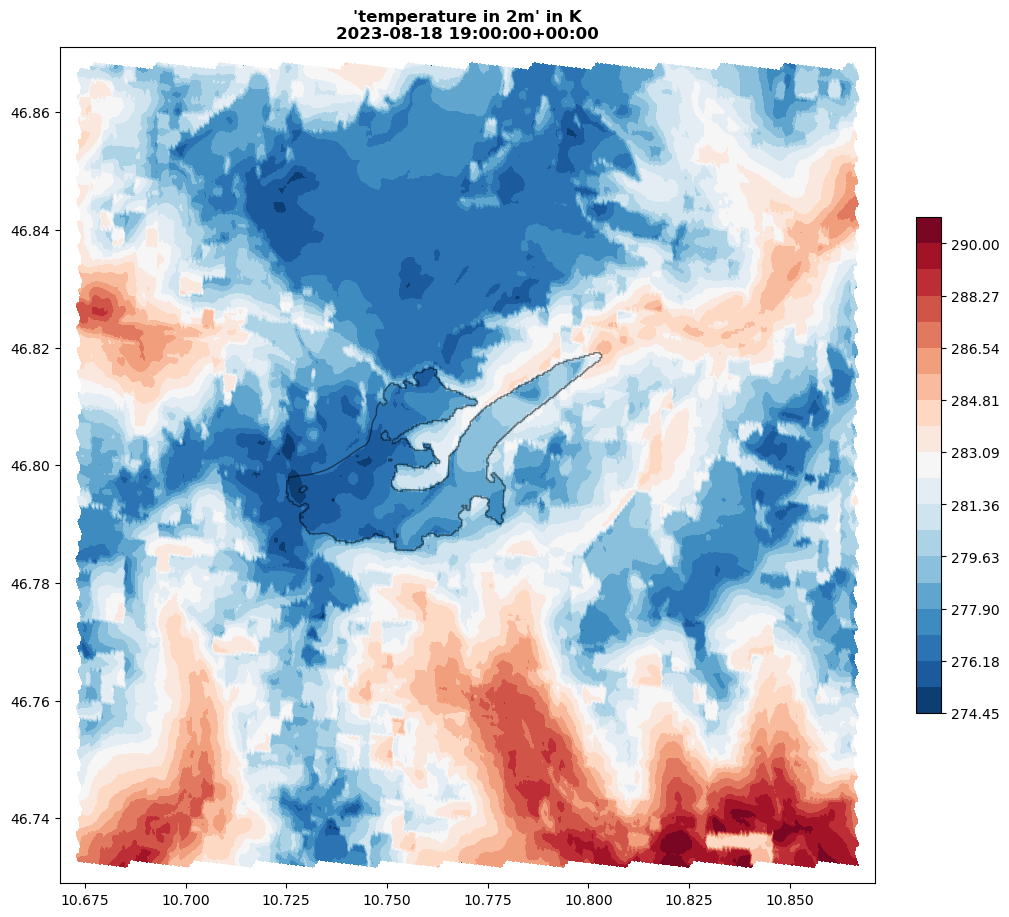

In [4]:
# init grid with files for 51m domain
grid_51 = ICONGrid(file_51_grid, file_51_extpar)

# init data grid
datagrid_51 = grid_51.get_ICONDataGrid(file_51_data_grid)
datagrid_51.plot_variable_2D(var='t_2m', time=0, no_zeros=True, outlines=rgi_hef, cmap='RdBu_r')

### Plot 2: Rasterize data ###

Since ICON uses a triangular grid, the plotting routine uses either `GeoPandas` or Matplotlib's `tricontourf` function. However, sometimes it is useful to convert the data to a raster with a given resolution. An easy way to plot a raster is the `imshow` function with the extent of the grid.

<div class="alert alert-block alert-info">
<b>Note:</b> This is a simple method to rasterize the triangular ICON grid. However, <code>CDO</code> (<code>$ cdo remapcon</code>) offers a much better option to convert and interpolate ICON grid.
</div>

/Users/geoalxx/Python/ICONProcessor/ICONProcessor/ICONGrid.py:126: RuntimeWarning: invalid value encountered in divide
  rasters[v] = rasters[v] / counter


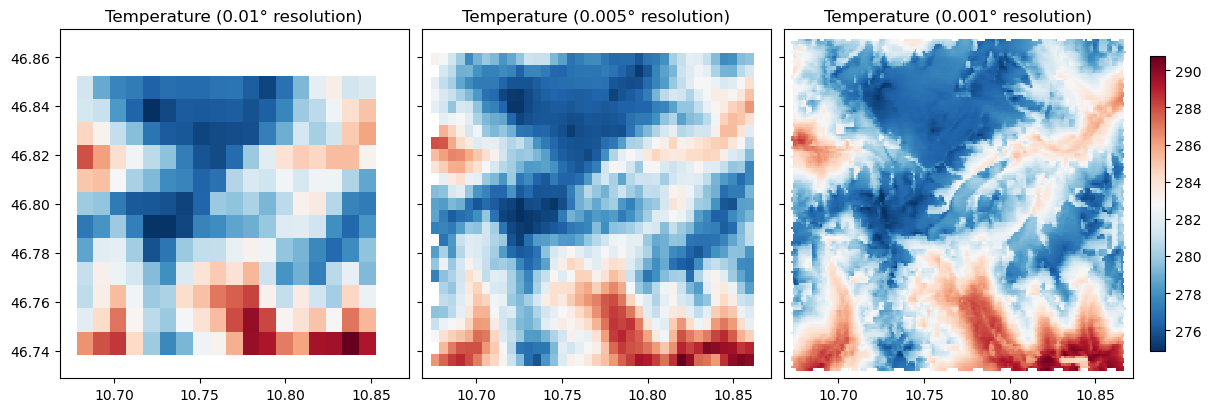

In [5]:
# function to plot a raster with imshow
def plot_raster(ax, raster, extent, aspect, title, cmap='RdBu_r', cb=False):
    im = ax.imshow(raster, origin='lower', interpolation='none', cmap=cmap, extent=extent)
    ax.set_aspect(aspect)
    ax.set_title(title)
    ax.grid(False)
    if cb:
        fig.colorbar(im, ax=ax, shrink=.6)

# get extent from ICONGrid and prepare imshow extent and aspect for plotting
gdf_cells = grid_51.get_triangles()
ex = grid_51.extent
im_ext = [ex['lon_min'], ex['lon_max'], ex['lat_min'], ex['lat_max']]
aspect = (ex['lon_max'] - ex['lon_min']) / (ex['lat_max'] - ex['lat_min'])

# plot three different resolutions of temperature for 51m grid
fig, axs = plt.subplots(figsize=(12,5), sharex=True, sharey=True, ncols=3, nrows=1, constrained_layout=True)

raster = grid_51.rasterize(gdf_cells, ['t_2m'], 0.01)
plot_raster(axs[0], raster['t_2m'], im_ext, aspect, 'Temperature (0.01° resolution)')

raster = grid_51.rasterize(gdf_cells, ['t_2m'], 0.005)
plot_raster(axs[1], raster['t_2m'], im_ext, aspect, 'Temperature (0.005° resolution)')

raster = grid_51.rasterize(gdf_cells, ['t_2m'], 0.001)
plot_raster(axs[2], raster['t_2m'], im_ext, aspect, 'Temperature (0.001° resolution)', cb=True)

plt.show()

**Hint**: If you want to rasterize with a very high resolution, the ICON data might not be sufficient and will result in data gaps. In this case, you can interpolate the data.

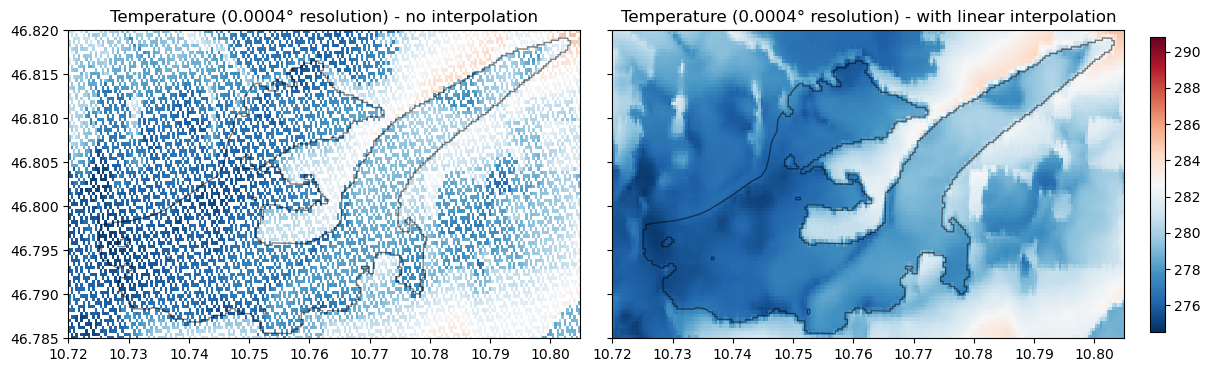

In [6]:
# define very high resolution
res = 0.0004

# plot part of the data without and with interpolation 
fig, axs = plt.subplots(figsize=(12,5), sharex=True, sharey=True, ncols=2, nrows=1, constrained_layout=True)

raster = grid_51.rasterize(gdf_cells, ['t_2m'], res)
plot_raster(axs[0], raster['t_2m'], im_ext, aspect, f'Temperature ({res}° resolution) - no interpolation')

raster = grid_51.rasterize(gdf_cells, ['t_2m'], res, interpolate=True)
plot_raster(axs[1], raster['t_2m'], im_ext, aspect, f'Temperature ({res}° resolution) - with linear interpolation', cb=True)

# show glacier outline and zoom in
for ax in axs:
    rgi_hef.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.5)
    ax.set_xlim(10.72, 10.805)
    ax.set_ylim(46.785, 46.82)

plt.show()

### Plot 3: Show wind map at surface level for specific timestamp

* Extent has been defined manually to show area of glacier
* Wind barbs have been modified to weaker wind conditions:
    * half: 2 m/s
    * full: 4 m/s
    * flag: 8 m/s

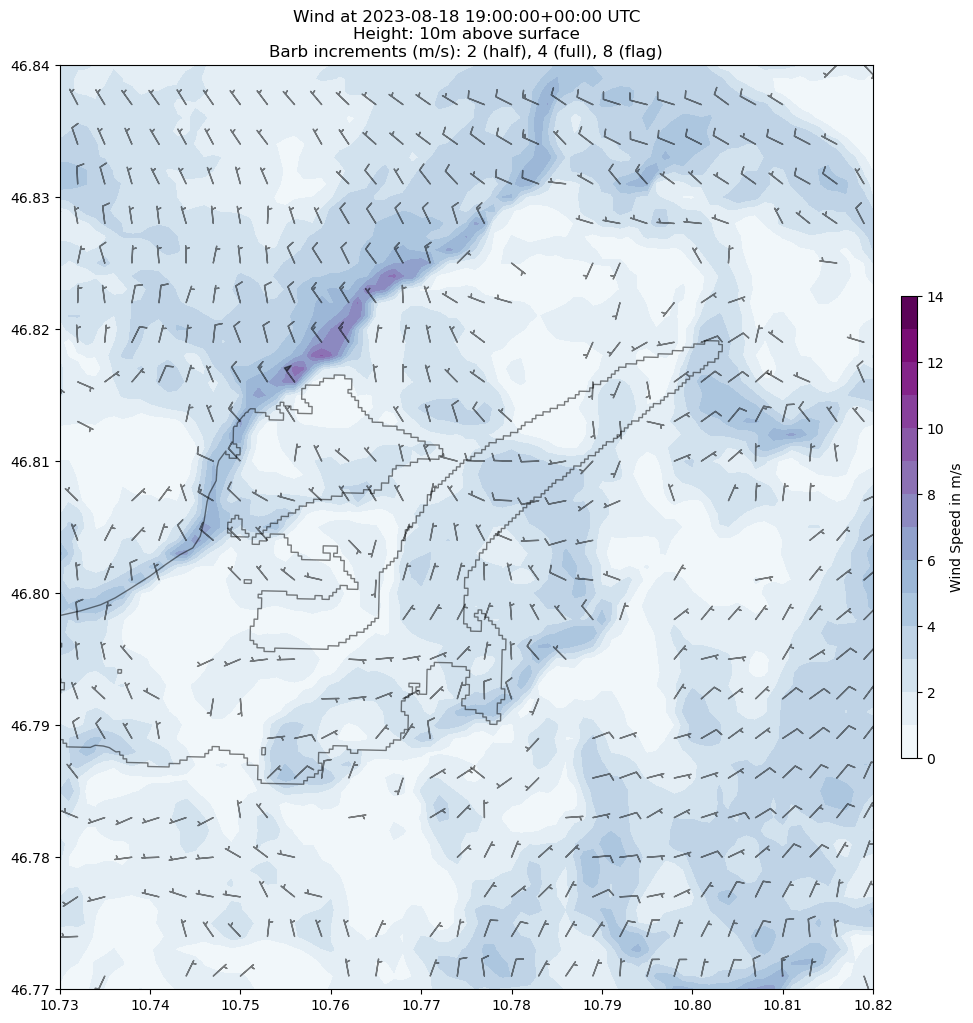

In [7]:
datagrid_51.plot_wind_map(time=0, surface=True, outlines_gdf=rgi_hef,
                          xlim=(10.73, 10.82), ylim=(46.77, 46.84), 
                          cb_range=range(0, 15, 1),
                          barb_distance=3,
                          coords_precision=3,
                          barb_increments=dict(half=2, full=4, flag=8))

### Plot 4: Show wind map at specific height above surface for specific timestamp

* original extent of domain
* Wind barbs have been modified to moderate wind conditions:
    * half: 3 m/s
    * full: 6 m/s
    * flag: 30 m/s

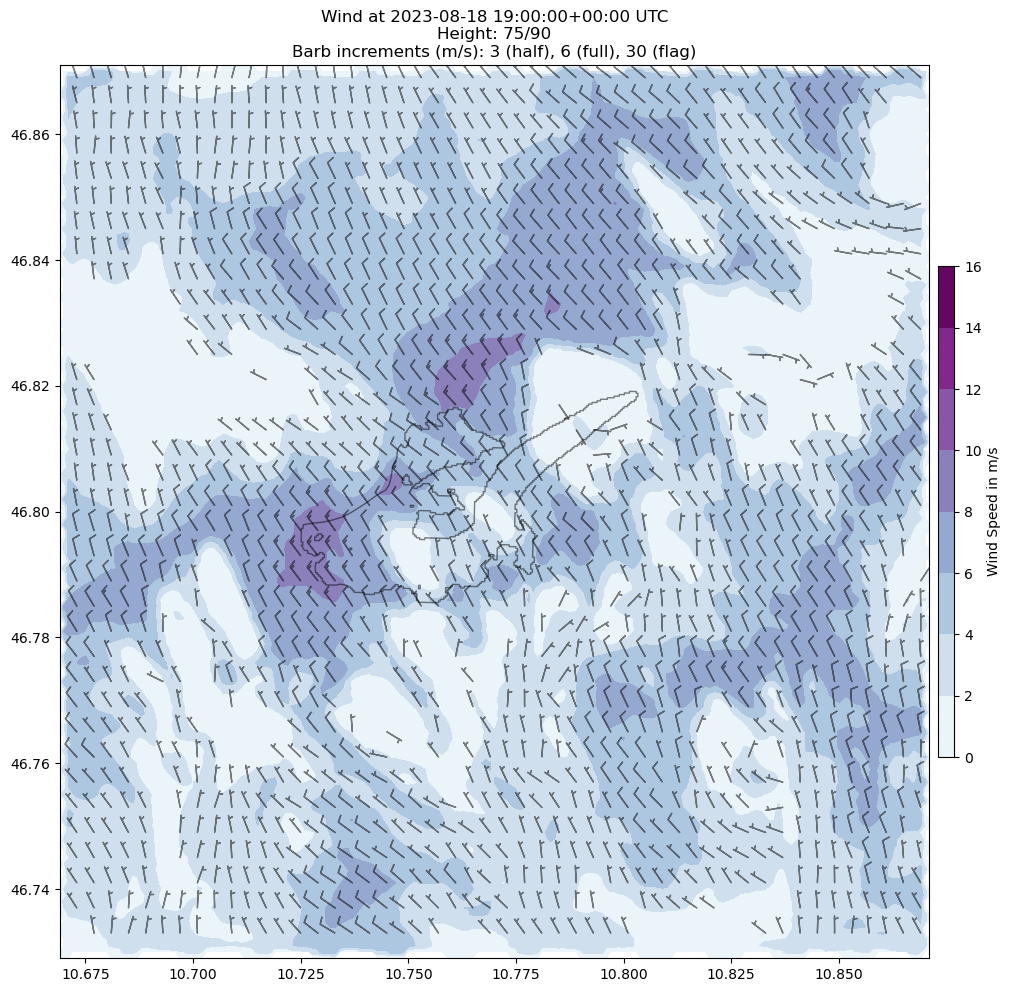

In [8]:
datagrid_51.plot_wind_map(time=0, surface=False, height=-16, outlines_gdf=rgi_hef,
                          cb_range=range(0, 18, 2),
                          barb_distance=4,
                          coords_precision=3,
                          barb_increments=dict(half=3, full=6, flag=30))